## Predição de Fraudes "Card Not Present" (IEEE-CIS Dataset)

O problema escolhido para realização do projeto foi de fraudes em transações sem cartão presencial, conhecidas como **"Card Not Present Fraud"**. Os dados foram preparados e disponibilizados pela IEEE Computational Intelligence Society e lançados durante uma competição [IEEE-CIS Fraud Detection](https://www.kaggle.com/competitions/ieee-fraud-detection/overview) no Kaggle.

O que torna esse projeto mais interessante é que os dados são de **transações reais** foram fornecidos pela [Vesta Corporation](https://vesta.io/). A Vesta é uma empresa especializada em soluções de proteção contra fraudes e processamento de pagamentos para transações móveis e online. A empresa utiliza modelos avançados de *machine learning* para analisar mais de US$ 4 bilhões em transações anualmente, fornecendo serviços que permitem a aprovação de vendas em milissegundos e o processamento de pagamentos em mais de 40 países.

O conjunto de dados possui cerca de 600.000 registros e contém mais de 430 características. Portanto, além do desafio de modelagem para predição de fraudes, é preciso considerar o grande volume de dados e a alta dimensionalidade. Por serem transações reais, um grande número de *features* foram anonimizadas, garantindo a privacidade dos clientes, portanto, não é possível saber qual o conteúdo real de todas as variáveis.

### Definição do problema

Imagine a seguinte situação. Você compra um café da manhã na padaria e se dirige ao caixa para pagar. Como é muito comum nos tempos atuais, você utiliza seu telefone para pagar, usando um cartão digital por aproximação, mas sua compra é negada. Ou você decide aproveitar as promoções de fim de ano em determinada plataforma de e-commerce, preenche as informações do seu cartão, mas sua compra não pode ser efetuada.

Embora você tenha certeza que possui dinheiro suficiente para realizar a compra, por algum motivo sua transação não é efetuada. Isso acontece por que, todos os anos, mais de 30 bilhões de dólares são movimentados em transações fraudulentas de cartões de crédito e as empresas envolvidas nesses serviços, como bancos, instituições de pagamento e prestadoras de serviço, investem pesado em **sistemas de prevenção de fraude**. Apesar de nem sempre serem acertivos, como no caso descrito acima quando houve uma falso positivo, esses sistema podem evitar uma grande dor de cabeça para os clientes e para essas instituições.

A fraude em transações "Card Not Present" (CNP) ocorre quando compras são realizadas sem a presença física do cartão. Com o avanço da tecnologia e a popularização das compras pela internet, esse tipo de transação tornou-se predominante. No Brasil, por exemplo, 61% dos consumidores preferem comprar online em vez de em lojas físicas, e 78% realizam pelo menos uma compra mensal pela internet. Nessas compras, os consumidores inserem os dados do cartão, como número, data de validade e código de segurança, ou utilizam carteiras digitais em dispositivos móveis, facilitando as transações, mas também aumentando os riscos de fraude.

Considerando esse cenário, o objetivo do trabalho é criar um **modelo de classificação** capaz de estimar a probabilidade das trações serem verdadeiras ou fraudes. Em paralelo, também discutir conceitos importantes desse tipo de problema, como classes desbalanceadas, redução de dimensionalidade e uso adequado de métricas.

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# sklearn utils
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, precision_score, average_precision_score, recall_score, f1_score

# sklearn models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# other ml tools
from lightgbm import LGBMClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Análise Exploratória de Dados

Como discutido, neste problema vamos criar um classificador para prever a probabilidade de uma transação ser fraudulenta, indicada pelo alvo binário `isFraud`. Os dados de treinamento do Kaggle estão divididos em dois arquivos, `train_identity.csv` e `train_transaction.csv`, que são unidos pela chave `TransactionID`.

Por ser uma competição, o Kaggle não permite baixar os arquivos sem fazer login, por isso, não foi possível ler os dados através da URL. Foi necessário baixar os arquivos, que podem ser encontrados na pasta `/data` e ler localmente. 

#### Identity

In [118]:
train_identity = pd.read_csv('data/train_identity.csv')
train_identity.shape

(144233, 41)

In [119]:
train_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [120]:
identity_columns = train_identity.columns.difference(['TransactionID'])

#### Transaction

Por causa do grande volume de *features* nos dados de transações (394), vamos ler os dados em *chunks* ou blocos de 100.000 registros, o que otimiza a alocação de memória da máquina. Após concatenar os blocos em um único DataFrame, podemos deletar esses blocos para economizar recursos.

In [121]:
transaction_chunks = pd.read_csv('data/train_transaction.csv', chunksize=10 ** 5)
train_transaction = pd.concat(transaction_chunks)

train_transaction.shape

(590540, 394)

In [122]:
train_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
del transaction_chunks

In [124]:
associated = np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique()))
total_transaction = train_transaction.shape[0]

pct_records = np.divide(associated, total_transaction) * 100

print(f'{pct_records:.2f}% dos registros em "Transaction" ({total_transaction}) possuem registros de "Identity" associados.')

24.42% dos registros em "Transaction" (590540) possuem registros de "Identity" associados.


#### isFraud

Em alguns casos específicos de modelagem preditiva, lidamos com um problema conhecido como “classes desbalanceadas”. Isso acontece quando queremos classificar determinado exemplo, seja em tarefas binárias ou de múltiplas classes, mas os dados de treinamento específicos não apresentam uma distribuição equilibrada dessas classes. Vamo verificar se esse é o caso em nosso conjunto de dados:

In [125]:
train_transaction['isFraud'].value_counts(normalize=True).round(4) * 100

isFraud
0    96.5
1     3.5
Name: proportion, dtype: float64

Em problemas de detecção de fraudes, assim como predição de CHURN ou doenças raras, o fenômeno que queremos prever, geralmente, é subrepresentado nos dados de treino. Como podemos ver, isso aconte em nosso conjunto de dados, uma vez que apenas 3,5% do dados de treino são positivos para fraude.

Quando há desbalanceamento de classes é necessário conhecer algumas técnicas para lidar com esse problemas de forma eficiente, que pode ser abordado pela via da reamostragem, buscando equilibrar as classes removendo exemplos da classe majoritária ou criando exemplos artificiais da classe minoritária. Outra abordagem é o uso correto de métricas de avaliação.

A acurácia é uma métrica muito usada em problemas gerais, mas que não tem grande utilidade para esse problema específico. Imagine que o modelo aprenda a dizer que todas as transações são verdadeiras, a acurácia seria próxima de 97%, mas nosso modelo seria muito ruim. Métricas mais adequadas são a **precisão** e o **recall**, que juntas formam o **F1 score**.

Essa métricas são calculadas apartir do número de falsos positivos ou falsos negativos e do verdadeiros positivos. Assim, podemos ajustar nosso modelo mais adequadamente para nosso objetivo alvo: minimizar falsos positivos (recall) ou minimizar falsos negativos (precisão). Vamos discutir essas técnicas mais profundamente ao longo do trabalho.

#### TransactionAmt

KeyboardInterrupt: 

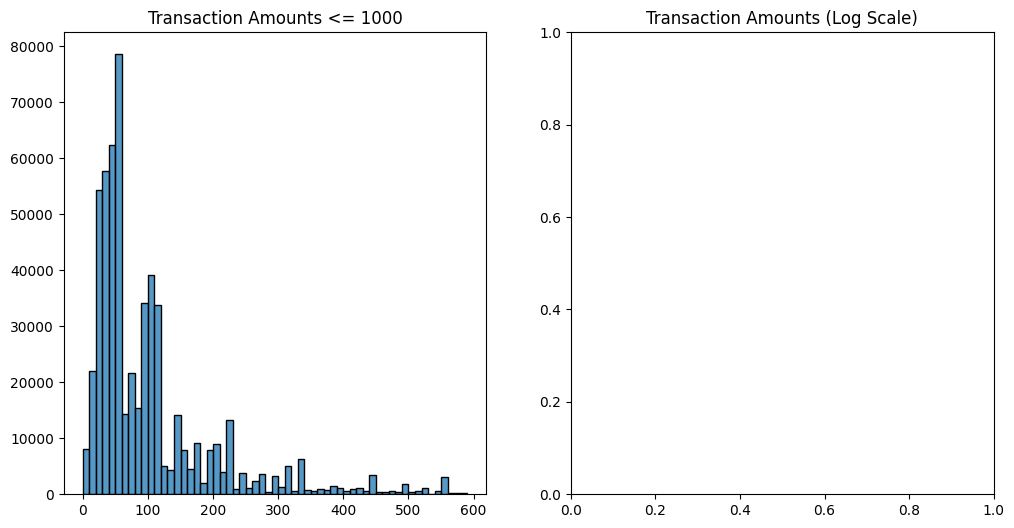

In [126]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=False)

ax1.set_title('Transaction Amounts <= 1000')
ax2.set_title('Transaction Amounts (Log Scale)')

sns.histplot(train_transaction.loc[train_transaction['TransactionAmt'] <= 1000], x='TransactionAmt', bins=100, ax=ax1)
sns.histplot(train_transaction, x='TransactionAmt', bins=100, log_scale=True, ax=ax2)

plt.tight_layout()
plt.show()

A análise dos valores de transações revela uma distribuição altamente concentrada em valores baixos, com a maioria das transações ocorrendo abaixo de 200. Essa característica aponta para um desbalanceamento nos dados, com uma pequena proporção de transações de valores significativamente altos. Em termos de modelagem de machine learning, isso implica na necessidade de estratégias específicas para lidar com a amplitude dos dados e a presença de outliers. Transformações, como o uso de escalas logarítmicas, podem ser úteis para estabilizar a variância e melhorar o desempenho de modelos sensíveis à escala. 

Além disso, a predominância de transações de baixo valor sugere que os modelos podem precisar de ajustes para evitar vieses que priorizem padrões comuns e negligenciem a detecção de eventos raros, como fraudes em transações de valores elevados. Avaliar o impacto dessas transações menos frequentes será crucial para garantir que o modelo seja robusto e eficaz em diferentes cenários.

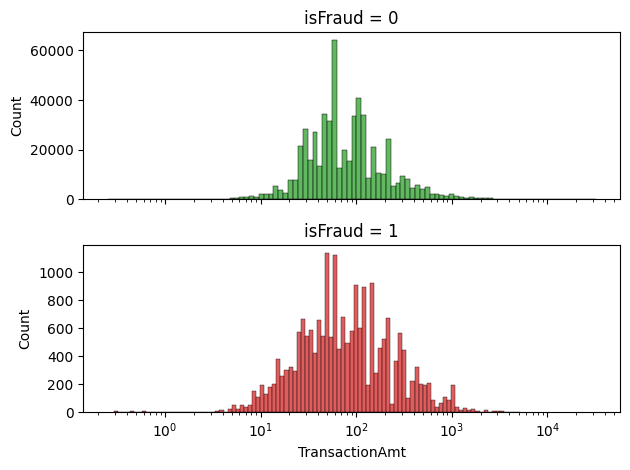

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.set_title('isFraud = 0')
ax2.set_title('isFraud = 1')

sns.histplot(train_transaction.loc[train_transaction['isFraud'] == 0], x='TransactionAmt', color='tab:green', bins=100, log_scale=True, ax=ax1)
sns.histplot(train_transaction.loc[train_transaction['isFraud'] == 1], x='TransactionAmt', color='tab:red', bins=100, log_scale=True, ax=ax2)

plt.tight_layout()
plt.show()

In [ ]:
fraud = train_transaction['isFraud'] == 1

mean_fraud = np.mean(train_transaction.loc[fraud, 'TransactionAmt'])
mean_not_fraud = np.mean(train_transaction.loc[~fraud, 'TransactionAmt'])

print(f"Valor médio por transações isFraud == 1 é {mean_fraud:.2f}")
print(f"Valor médio por transações isFraud == 0 é {mean_not_fraud:.2f}")

Valor médio por transações isFraud == 1 é 149.24
Valor médio por transações isFraud == 0 é 134.51


A análise dos dados revela que transações fraudulentas possuem, em média, valores ligeiramente superiores às transações não fraudulentas (149,24 contra 134,51). No entanto, essa diferença de médias é relativamente pequena, e as distribuições de valores para ambos os casos mostram uma sobreposição significativa. Isso indica que o valor da transação, isoladamente, não é um bom discriminador para identificar fraudes.

Apesar disso, o valor da transação pode ser uma variável útil quando combinado com outros fatores, já que existe uma leve tendência de fraudes ocorrerem em transações com valores mais elevados. Para maximizar sua utilidade em um modelo de machine learning, seria interessante explorar interações com outras variáveis, realizar transformações como escalas logarítmicas e investigar a influência de outliers.

Vamos explorar mais algumas variáveis:

#### Card Issuer

In [13]:
train_transaction['card4'].value_counts(dropna=False)

card4
visa                384767
mastercard          189217
american express      8328
discover              6651
NaN                   1577
Name: count, dtype: int64

In [ ]:
pct_card_fraud = train_transaction.groupby(['card4', 'isFraud'])['TransactionAmt'].sum() / train_transaction.groupby(['card4'])['TransactionAmt'].sum()
pct_card_fraud = (pct_card_fraud * 100).unstack(level=0).reset_index(drop=True)

pct_card_fraud

card4,american express,discover,mastercard,visa
0,97.030419,89.702981,96.583877,96.100993
1,2.969581,10.297019,3.416123,3.899007


#### Transaction Type

In [15]:
train_transaction['card6'].value_counts(dropna=False)

card6
debit              439938
credit             148986
NaN                  1571
debit or credit        30
charge card            15
Name: count, dtype: int64

#### DeviceType

In [16]:
train_identity['DeviceInfo'].unique()

array(['SAMSUNG SM-G892A Build/NRD90M', 'iOS Device', 'Windows', ...,
       'LDN-LX3 Build/HUAWEILDN-LX3', 'Z955A', 'LG-E975'], dtype=object)

In [17]:
train_identity['DeviceType'].value_counts(dropna=False)

DeviceType
desktop    85165
mobile     55645
NaN         3423
Name: count, dtype: int64

#### E-mail Domain

In [18]:
train_transaction['R_emaildomain'].value_counts(dropna=False)

R_emaildomain
NaN                453249
gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
                    ...  
frontiernet.net        14
netzero.com            14
centurylink.net        12
netzero.net             9
sc.rr.com               8
Name: count, Length: 61, dtype: int64

In [ ]:
pct_email_fraud = train_transaction.groupby(['R_emaildomain', 'isFraud'])['TransactionAmt'].sum() / train_transaction.groupby(['R_emaildomain'])['TransactionAmt'].sum()
pct_email_fraud = (pct_email_fraud * 100).unstack('isFraud').dropna()

pct_email_fraud.sort_values(by=1, ascending=False).head(10)

isFraud,0,1
R_emaildomain,,
protonmail.com,2.402264,97.597736
mail.com,48.574506,51.425494
netzero.net,55.645161,44.354839
icloud.com,78.613555,21.386445
outlook.com,80.013195,19.986805
outlook.es,84.345394,15.654606
gmail.com,84.677812,15.322188
earthlink.net,85.056705,14.943295
live.com.mx,90.093109,9.906891


### Análise de Componentes Principais (PCA)

Conforme apresentado no início do notebook, os dados de treino estão dividios em dois conjuntos, transações e identidade, que compartilham a chave `TransactionID`. É necessário realizar o *join* dessas duas tabelas, de modo que a máquina consiga processar esses relacionamentos sem exceder o limite de memória.

Além disso, por serem quase 600.000 registros, vamos criar uma amostra estratificada de 10% do conjunto original com objetivo de reduzir o tempo de treinamento de modelos, permitindo testar diversas combinações em menos tempo. Depois que estivermos satisfeitos com modelo escolhido e os parâmetros, podemos utilizar o *dataset* completo para treinar o modelo final.

A amostragem estratificada é uma técnica que permite criar subgrupos homogêneos (estratos) com base em características relevantes para o estudo. No nosso caso, é fundamental manter a proporção de fraudes e transações verdadeira ou poderíamos correr o risco de criar uma amostra aleatória em que o desbalanceamento das classes fosse ainda mais acentuado.

In [20]:
merged_chunks = []
transaction_chunks = pd.read_csv('data/train_transaction.csv', chunksize=10 ** 5)

for chunk in transaction_chunks:
    new_chunk = chunk.merge(train_identity, on='TransactionID', how='left')
    merged_chunks.append(new_chunk)

train = pd.concat(merged_chunks)

Outra categoria que deve ser levada em consideração ao realizar a amostra estratificada é a `hasIdentity`, que representa a preseção de dados correspondentes da tabela de identidade. Sem considerar essa variável, podemos criar uma amostra aleatória em que grande parte das transações tenham identidade correspondente, o que pode enviesar nosso modelo.

In [21]:
train['hasIdentity'] = (train[identity_columns].isna().all(axis=1) == False).astype(int)
train['hasIdentity'].value_counts(normalize=True)

hasIdentity
0    0.755761
1    0.244239
Name: proportion, dtype: float64

In [22]:
train = train.groupby(['hasIdentity', 'isFraud'], group_keys=False)[train.columns].apply(lambda x: x.sample(frac=0.1))

train.shape

(59054, 435)

In [23]:
train['hasIdentity'].value_counts(normalize=True)

hasIdentity
0    0.755749
1    0.244251
Name: proportion, dtype: float64

In [24]:
del train_identity, transaction_chunks

Analisando as *features* do nosso conjunto de dados, observamos que existem 339 variáveis que começam com a letra 'V' e são seguidas de um número, entre 1 e 339. Segundo a [descrição dos dados](https://www.kaggle.com/competitions/ieee-fraud-detection/discussion/101203) disponibilizada pelo Kaggle, essas são *features* criadas pela Vesta, empresa que disponibilizou o *dataset*, após um processo próprio de feature engineering. A descrição não fornece maiores detalhes sobre a criação dessas variáveis.

Por serem muito numerosas, o que exige maior poder computacional e pode dificultar a capacidade do modelo de generalizar bem os dados, vamos conduzir um processo de redução de dimensionalidade.

Para isso, utilizaremos a técnica de Análise de Componentes Principais (PCA), que permite transformar as features originais em um novo conjunto de variáveis não correlacionadas, chamadas de componentes principais. Esses componentes são ordenados de forma a capturar a maior variância possível dos dados nas primeiras dimensões, permitindo que descartemos as componentes menos relevantes. Assim, conseguimos reduzir a complexidade do modelo, preservando a maior parte da informação contida nas features originais.

In [25]:
X_train = train.loc[:, train.columns.str.startswith('V')]

print(f'Número de features escolhidas: {X_train.shape[1]}')

Número de features escolhidas: 339


In [26]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

X_train_transformed = numeric_transformer.fit_transform(X_train)

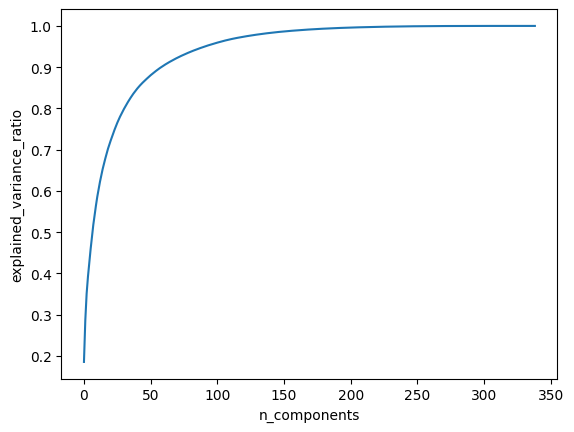

In [27]:
pca = PCA(random_state=23)
pca.fit(X_train_transformed)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("n_components")
plt.ylabel("explained_variance_ratio")

plt.show()

O gráfico acima mostra a variância explicada acumulada em função do número de componentes principais após utilizar o PCA (Principal Component Analysis). Inicialmente, a variância explicada aumenta rapidamente com o acréscimo dos primeiros componentes. Isso indica que esses componentes capturam a maior parte da variância dos dados. Conforme mais componentes são adicionados, o crescimento da variância explicada desacelera, porque os componentes adicionais capturam porções cada vez menores da variância. Cerca de 50 a 60 componentes já explicam uma grande fração da variância total (provavelmente mais de 90%).

Sendo assim, podemos determinar uma fração aceitável da variância (95%, por exemplo) e determinar quantos componentes são necessários para capturar essa fração. Dessa forma, é possível reduzir o dataset de muitas dimensões para apenas `d`, otimizando o desempenho de algoritmos posteriores e os recursos necessários para treiná-los. O código abaixo encontra o valor de `d`, que será usada mais para frente durante o pré-processamento, para determinada variação *target*.


In [28]:
target_variance_ratio = 0.95
d = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= target_variance_ratio) + 1

print(f"Número de dimensões para manter {target_variance_ratio*100}% da variância: {d}")

Número de dimensões para manter 95.0% da variância: 92


### Feature Engineering

O processo de *feature engineering* aplicado ao conjunto de dados foi realizado com o objetivo de criar novas variáveis mais informativas e tratar valores que poderiam impactar negativamente o desempenho do modelo. 

In [29]:
train.loc[~train['card6'].isin(['credit', 'debit']), 'card6'] = np.nan

train['card6'].value_counts(dropna=False)

card6
debit     44236
credit    14645
NaN         173
Name: count, dtype: int64

Foi realizado um processo de criação de novas features utilizando a variável TransactionAmt (valor da transação) e as variáveis categóricas card1, card4, card6, P_emaildomain, R_emaildomain e addr1. Para cada uma dessas colunas, foram criadas as seguintes features derivadas: `amount_mean` e `amount_std`.

Essas variáveis têm o objetivo de capturar o quanto o valor de uma transação específica se desvia da média ou da dispersão geral das transações para cada categoria. Isso pode ajudar a identificar comportamentos atípicos. Uma transformação logarítmica também foi aplicada à variável `TransactionAmt`, criando a nova feature `TransactionAmtLog`. A transformação logarítmica é útil para reduzir a assimetria de distribuições muito enviesadas e facilitar a modelagem.

In [30]:
amount = 'TransactionAmt'
selected_cols = ['card1', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'addr1']

for col in selected_cols:
    train[f'amount_mean_{col}'] = train[amount] / train.groupby([col])[amount].transform('mean')
    train[f'amount_std_{col}'] = train[amount] / train.groupby([col])[amount].transform('std')

In [31]:
log_amount = 'TransactionAmtLog'
train[log_amount] = np.log(train[amount])

for col in selected_cols:
    train[f'log_amount_mean_{col}'] = train[log_amount] / train.groupby([col])[log_amount].transform('mean')
    train[f'log_amount_std_{col}'] = train[log_amount] / train.groupby([col])[log_amount].transform('std')

In [32]:
train[['amount_mean_card6', 'log_amount_mean_card6']]

,amount_mean_card6,log_amount_mean_card6
73220,0.498917,0.946916
60605,0.421432,0.907547
50727,1.833809,1.250546
31575,1.007304,1.110799
44101,0.311549,0.884973
...,...,...
34520,0.314060,0.886723
45838,0.145654,0.659732
31476,1.612853,1.243403
32568,1.075235,1.155013


In [33]:
train['TransactionAmtCents'] = (train[amount] - np.floor(train[amount])).astype(np.float64).round(2)

Outro passo importante foi a conversão da variável `TransactionDT`, que representa um timestamp relativo, em uma data real. Para isso, foi definida uma data de referência inicial (2022-01-01), e a partir do número de segundos em TransactionDT, foi calculada a data exata de cada transação. A partir dessa data, foram extraídas novas features de data e tempo: dia da semana, dia e hora.

In [34]:
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')

train['Date'] = train['TransactionDT'].apply(lambda dt: start_date + timedelta(seconds=dt))

train['Weekday'] = train['Date'].dt.dayofweek
train['Day'] = train['Date'].dt.day
train['Hour'] = train['Date'].dt.hour

train = train.drop(columns=['Date'])

In [ ]:
train[['TransactionDT', 'Weekday', 'Day', 'Hour']].sample(5)

,TransactionDT,Weekday,Day,Hour
90531,1888687,5,22,20
32246,8184515,1,5,17
50979,14567460,5,18,14
11595,2171946,2,26,3
17555,482172,3,6,13


In [36]:
train.shape

(59054, 464)

O conjunto de dados final para treinamento do modelo possui 463 features (desconsiderando a variável target), entre as quais 29 foram criadas durante o processo de criação de features (*feature engineering*). Também devemos considerar que, ao realizar a análise de componentes principais, identificamos que 339 features podem ser representadas por aproximadament 90 componenetes principais, mantendo 95% da variância do conjunto de features original.

Portanto, mesmo com a redução significativa de dimensionalidade, nosso modelo ainda deve analisar cerca de 214 features, buscando encontrar padrões que ajudem a prever a ocorrência de fraudes.

### Pré-processamento

Apesar da maior parte das features ser númerica, algumas delas representar na verdade variáveis categóricas. Essa informação, de quais são as variáveis categóricas, foi disponibilizada pelos organizadores da competição no Kaggle. Assim, mesmo sem os rótulos de algumas delas (M1-M9), por questão de proteção de dados reais, ainda é possível ter a informação e tratar essas variáveis adequadamente, durante o pré-processamento.

Categorical Features (Transaction)

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

Categorical Features (Identity)

- DeviceType
- DeviceInfo
- id_12 - id_38

Categorical Created Features

- hasIdentity
- Weekday
- Day
- Hour

In [37]:
CAT_FEATURES = [
    *[f'card{i}' for i in range(1, 7)],
    *[f'M{i}' for i in range(1, 10)],
    *[f'id_{i}' for i in range(12, 39)],
    "ProductCD",
    "addr1", 
    "addr2",
    "P_emaildomain",
    "R_emaildomain",
    "DeviceType",
    "DeviceInfo",
    "hasIdentity",
    "Weekday",
    "Day",
    "Hour",
]

In [ ]:
X = train.drop(columns=['isFraud'])
y = train['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=23)

print(X_train.shape)
print(y_train.shape)

(41337, 463)
(41337,)


In [39]:
X_train = X_train.replace([np.inf, -np.inf], -999)
X_test = X_test.replace([np.inf, -np.inf], -999)

In [40]:
pca_features = X_train.columns[X_train.columns.str.startswith('V')]
cat_features = np.unique(CAT_FEATURES + X_train.select_dtypes(include=['object']).columns.tolist())
num_features = [col for col in X_train.columns if col not in cat_features and col not in pca_features]

print(np.sum(list(map(len, [pca_features, cat_features, num_features]))))

463


Após separar as variáveis numéricas, categóricas, e as que serão usadas no PCA transformer (V1-V339), vamos a abordagem de `Pipeline` do Scikit-Learn para definir as transformações que vamos realizar.

As variavéis categóricas serão, primeiramente, transformadas em *string*, depois será feita a imputação de dados faltantes, usando a abordagem de mais frequente, ou seja, substitui os NaNs pela categoria mais frequente. Por fim, esses dados serão transformados em inteiros, usando o codificador `OrdinalEncoder`. Quando o modelo se deparar com uma categoria desconhecida, que não estava presente nos dados de treino, essa valor será codificado como -1.

Para as variáveis categórias usaremos uma abordagem de tratamento de valores faltantes similar, substituindo NaNs pela média. Após imputar os dados, usaremos o `StandarScaler` para uniformizar a distribuição dos dados.

As variáves V1 até V339, que foram submetidas à análise de componentes principais, vão passar pelo mesmo processo das features numéricas. Ao final do processo da padronização das escalas, será aplicada a redução de dimensionalidade, através da criação dos componentes principais.

In [41]:
categorical_transformer = Pipeline(steps=[
    ('to_string', FunctionTransformer(lambda X: X.astype(str))),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

pca_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=d))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_features),
        ('num', numeric_transformer, num_features),
        ('pca', pca_transformer, pca_features)
    ],
    remainder='passthrough'
)

Após definir os transformadores, vamos aplicar a `Pipeline` ao conjunto de treino e teste de forma distinta. Para o conjunto de treino, usamos o método `fit_transform()` que aprende a escala dos dados e cardinalidade das categorias, além de aplicar as transformações. Já o método `transform()` apenas vai aplicar no conjunto de teste as transformações necessárias aprendidas usando o conjunto de treino.

Ao realizar esse processo de forma separada, garantimos que as transformações não são influenciadas por informações dos dados teste, que devem ser totalmente desconhecidos para nosso modelo. Se houver influencia dos dados de teste nos dados de treino, estaremos diante de uma problema chamado **data leakage** ou vazamento de dados

In [42]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [43]:
print(X_train_transformed.shape)
print(X_test_transformed.shape)

(41337, 216)
(17717, 216)


Antes das transformações nossos dados eram DataFrames do `pandas`. No entanto, o Scikit-Learn utiliza principalmente arrays para construir e treinar os modelos, portanto, nossos dados transformados de treino e teste agora são do tipo `ndarray`. Podemos excluir os antigos DataFrames de treino e teste para liberar espaço em memória.

In [44]:
del X_train, X_test

### Seleção de modelos

O processo de seleção de modelos realizado teve como objetivo comparar diferentes abordagens para prever a variável de interesse em um contexto de dados desbalanceados, utilizando a métrica ROC AUC como critério de avaliação.

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=23)
decision_tree.fit(X_train_transformed, y_train)

y_pred = decision_tree.predict(X_test_transformed)
y_pred.shape

(17717,)

In [ ]:
train_score = decision_tree.score(X_train_transformed, y_train)
test_score = decision_tree.score(X_test_transformed, y_test)

print("Train score: {}".format(train_score))
print("Test score: {}".format(test_score))

Train score: 1.0
Test score: 0.9485804594457301


In [ ]:
confusion_matrix(y_test, y_pred)

array([[16577,   520],
       [  391,   229]])

In [ ]:
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

ROC AUC: 0.6694700730367713
Precision: 0.30574098798397864
Recall: 0.36935483870967745
F1 Score: 0.3345507669831994


In [52]:
results = {}

k_folds = 10
cv = StratifiedKFold(n_splits=k_folds, shuffle=True)

models = {
    'LGBM': LGBMClassifier(verbose=-1, random_state=23, n_jobs=-1),
    'RF': RandomForestClassifier(random_state=23, n_jobs=-1),
    'BC': BaggingClassifier(random_state=23, n_jobs=-1),
    'DT': DecisionTreeClassifier(random_state=23),
}

for name, model in models.items():
    scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring='roc_auc')
    results[name] = scores

    print(f'{name}: {scores.mean()} ({scores.std()})')

LGBM: 0.8973332382445532 (0.017167333634640385)
RF: 0.8638294868271688 (0.02029299030454494)
BC: 0.7974580077907147 (0.016816668849680232)
DT: 0.67663105136618 (0.024908658875621145)


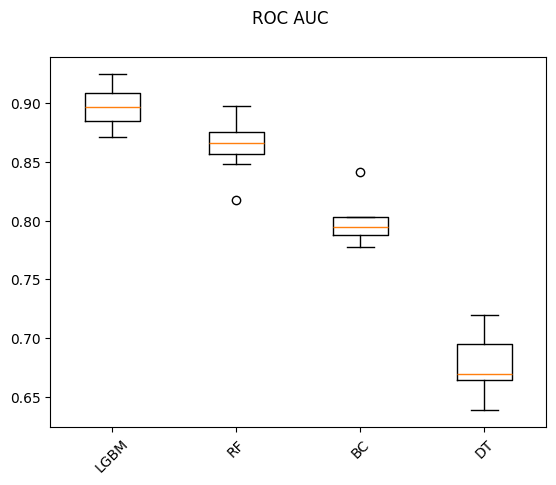

In [53]:
fig = plt.figure()
fig.suptitle('ROC AUC')

ax = fig.add_subplot(111)
plt.boxplot(results.values())

ax.set_xticks(range(1, len(results.keys()) + 1))
ax.set_xticklabels(results.keys(), rotation=45)

plt.show()

O primeiro grupo de modelos avaliados foi composto por algoritmos simples, como DecisionTree, e algoritmos de ensemble, como é o caso do LightGBM (boosting), BaggingClassifier e Random Forest. Podemos observar que os algoritmos de boosting e Random Forest foram os que tiveram melhor performance, considerando a métrica escolhida.

Em seguida vamos testar técnicas específicas para dados desbalanceados, como undersampling e oversampling (SMOTE). OS modelos UNDER_RF e RUSB aplicam técnicas de undersampling, com a diferença que o primeiro é um algoritmo de bagging e o segundo de boosting. Já o SMOTE_LGBM é uma implementação de um algoritmo de boosting, utilizando uma técnica de oversampling, chamada SMOTE.

In [54]:
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

X_train_res, y_train_res = undersampler.fit_resample(X_train_transformed, y_train)

scores = cross_val_score(RandomForestClassifier(random_state=23), X_train_res, y_train_res, cv=cv, scoring='roc_auc')
print(f'UNDER_RF: {scores.mean()} ({scores.std()})')

results['UNDER_RF'] = scores

UNDER_RF: 0.8651323655700885 (0.01827525373628547)


In [55]:
rus_boost = RUSBoostClassifier(random_state=23)

scores = cross_val_score(rus_boost, X_train_transformed, y_train, cv=cv, scoring='roc_auc')
print(f'RUSB: {scores.mean()} ({scores.std()})')

results['RUSB'] = scores

RUSB: 0.8176634696193357 (0.015229257090487442)


In [ ]:
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

scores = cross_val_score(LGBMClassifier(random_state=23, verbose=-1), X_train_res, y_train_res, cv=cv, scoring='roc_auc')
print(f'SMOTE_LGBM: {scores.mean()} ({scores.std()})')

results['SMOTE_LGBM'] = scores

SMOTE_LGBM: 0.9972452070911704 (0.0003087086097467943)


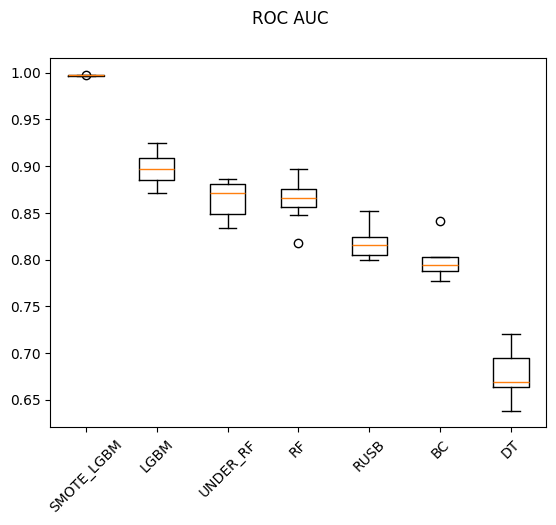

In [ ]:
sorted_results = dict(sorted(results.items(), key=lambda x: np.median(x[1]), reverse=True))

fig = plt.figure()
fig.suptitle('ROC AUC')

ax = fig.add_subplot(111)
plt.boxplot(sorted_results.values())

ax.set_xticks(range(1, len(sorted_results.keys()) + 1))
ax.set_xticklabels(sorted_results.keys(), rotation=45)

plt.show()

O SMOTE_LGBM apresentou um comportamento muito atípico indicando sinais de overfitting, mas o LightGBM continua sendo um algoritmo com boa performance, mesmo sem aplicar técnicas de reamostragem. As implementações de RandomForest se mostraram bastante competitivas e as duas tiveram performances similares.

A diferença entre o UNDER_RF e RF não está na métrica de ROC AUC, mas sim em outras métricas importantes, que vamos discutir mais para frente. É importante considerar que, ao reduzir o número de exemplos, aplicando o undersampling o processo de treinamento é muito mais rápido, pois lida com um volume menor de exemplos. Em contrapartida, é preciso estar atento para perda de informações e o risco de underfitting.

### Treinamento

Considerando os testes realizados durante a seleção de modelos, vamos testar em detalhe implementação diversar do algoritmo `RandomForestClassifier()`: 

#### Under Bagging

In [58]:
clf = RandomForestClassifier(random_state=23)
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=23)

X_train_res, y_train_res = undersampler.fit_resample(X_train_transformed, y_train)

clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test_transformed)

In [59]:
confusion_matrix(y_test, y_pred)

array([[13672,  3425],
       [  143,   477]])

In [ ]:
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

ROC AUC: 0.784513647932952
Precision: 0.12224500256278831
Recall: 0.7693548387096775
F1 Score: 0.210968597965502


#### SMOTE Bagging

In [61]:
clf = RandomForestClassifier(random_state=23, n_jobs=-1)
smote = SMOTE(sampling_strategy='minority', random_state=23)

X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test_transformed)

In [62]:
confusion_matrix(y_test, y_pred)

array([[17040,    57],
       [  393,   227]])

In [ ]:
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

ROC AUC: 0.681397557013398
Precision: 0.7992957746478874
Recall: 0.36612903225806454
F1 Score: 0.5022123893805309


#### Adjusted Weights Random Forest

In [64]:
clf = RandomForestClassifier(class_weight='balanced', random_state=23)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)

In [65]:
confusion_matrix(y_test, y_pred)

array([[17089,     8],
       [  510,   110]])

In [ ]:
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

ROC AUC: 0.5884757182452308
Precision: 0.9322033898305084
Recall: 0.1774193548387097
F1 Score: 0.2981029810298103


#### Precision/Recall Trade-off

In [ ]:
results = []
ratios = [None, 'majority', 0.5, 0.33, 0.2, 0.1]  # 2:1, 3:1, 5:1, 10:1
class_weights = [None, 'balanced', 'balanced_subsample', {0: 1, 1: 2}, {0: 1, 1: 10}]

for r in ratios:
    for cw in class_weights:
        clf = RandomForestClassifier(class_weight=cw, n_estimators=100, n_jobs=10, random_state=23)
        
        if r is not None:
            undersampler = RandomUnderSampler(sampling_strategy=r, random_state=23)
            X_train_res, y_train_res = undersampler.fit_resample(X_train_transformed, y_train)

            clf.fit(X_train_res, y_train_res)

        else:
            clf.fit(X_train_transformed, y_train)

        y_pred_proba = clf.predict_proba(X_test_transformed)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)

        results.append({
                        'undersampling_ratio': r,
                        'class_weight': cw,
                        'precision': precision,
                        'recall': recall,
                        'thresholds': thresholds,
                        'average_precision': avg_precision
                    })
        
        print(f"Done: Ratio={r}, Class Weight={cw}, Avg Precision={avg_precision:.4f}")

Done: Ratio=None, Class Weight=None, Avg Precision=0.5026
Done: Ratio=None, Class Weight=balanced, Avg Precision=0.5093
Done: Ratio=None, Class Weight=balanced_subsample, Avg Precision=0.5060
Done: Ratio=None, Class Weight={0: 1, 1: 2}, Avg Precision=0.5227
Done: Ratio=None, Class Weight={0: 1, 1: 10}, Avg Precision=0.5233
Done: Ratio=majority, Class Weight=None, Avg Precision=0.4349
Done: Ratio=majority, Class Weight=balanced, Avg Precision=0.4349
Done: Ratio=majority, Class Weight=balanced_subsample, Avg Precision=0.4312
Done: Ratio=majority, Class Weight={0: 1, 1: 2}, Avg Precision=0.4337
Done: Ratio=majority, Class Weight={0: 1, 1: 10}, Avg Precision=0.3858
Done: Ratio=0.5, Class Weight=None, Avg Precision=0.4714
Done: Ratio=0.5, Class Weight=balanced, Avg Precision=0.4591
Done: Ratio=0.5, Class Weight=balanced_subsample, Avg Precision=0.4588
Done: Ratio=0.5, Class Weight={0: 1, 1: 2}, Avg Precision=0.4594
Done: Ratio=0.5, Class Weight={0: 1, 1: 10}, Avg Precision=0.4211
Done: Rati

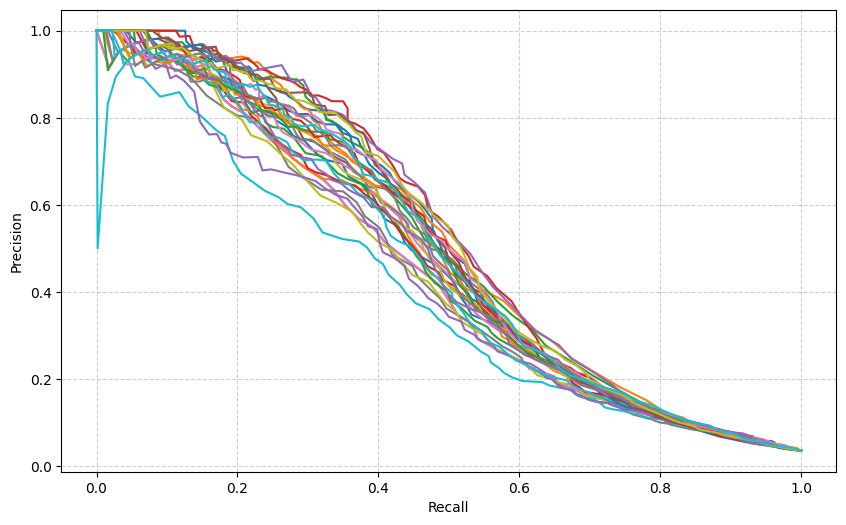

In [ ]:
plt.figure(figsize=(10, 6))

for result in results:
    ratio = result['undersampling_ratio']
    weight = result['class_weight']
    precision = result['precision']
    recall = result['recall']
    label = f"Ratio={ratio}, Weight={weight}, AP={result['average_precision']:.2f}"
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
results = []

for r in ratios:
    for cw in class_weights:
        clf = RandomForestClassifier(class_weight=cw, n_estimators=100, n_jobs=10, random_state=23)

        if r is not None:
            undersampler = RandomUnderSampler(sampling_strategy=r, random_state=23)
            X_train_res, y_train_res = undersampler.fit_resample(X_train_transformed, y_train)

            clf.fit(X_train_res, y_train_res)
        
        else: 
            clf.fit(X_train_transformed, y_train)

        y_pred = clf.predict(X_test_transformed)

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        results.append({
            'undersampling_ratio': r,
            'class_weight': cw,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc
        })

        print(f"Done: Ratio={r}, Class Weight={cw}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, ROC AUC={roc_auc:.4f}")

Done: Ratio=None, Class Weight=None, Precision=0.8765, Recall=0.2290, F1=0.3632, ROC AUC=0.6139
Done: Ratio=None, Class Weight=balanced, Precision=0.9322, Recall=0.1774, F1=0.2981, ROC AUC=0.5885
Done: Ratio=None, Class Weight=balanced_subsample, Precision=0.9297, Recall=0.1919, F1=0.3182, ROC AUC=0.5957
Done: Ratio=None, Class Weight={0: 1, 1: 2}, Precision=0.9161, Recall=0.2290, F1=0.3665, ROC AUC=0.6141
Done: Ratio=None, Class Weight={0: 1, 1: 10}, Precision=0.9254, Recall=0.2000, F1=0.3289, ROC AUC=0.5997
Done: Ratio=majority, Class Weight=None, Precision=0.1222, Recall=0.7694, F1=0.2110, ROC AUC=0.7845
Done: Ratio=majority, Class Weight=balanced, Precision=0.1222, Recall=0.7694, F1=0.2110, ROC AUC=0.7845
Done: Ratio=majority, Class Weight=balanced_subsample, Precision=0.1182, Recall=0.7613, F1=0.2046, ROC AUC=0.7777
Done: Ratio=majority, Class Weight={0: 1, 1: 2}, Precision=0.1392, Recall=0.7484, F1=0.2348, ROC AUC=0.7903
Done: Ratio=majority, Class Weight={0: 1, 1: 10}, Precision

In [99]:
results_df = pd.DataFrame(results)

max_precision_row = results_df.loc[results_df['precision'].idxmax()]
max_recall_row = results_df.loc[results_df['recall'].idxmax()]
max_f1_score_row = results_df.loc[results_df['f1_score'].idxmax()]
max_roc_auc_row = results_df.loc[results_df['roc_auc'].idxmax()]

print(f"Max Precision: Ratio={max_precision_row['undersampling_ratio']}, Class Weight={max_precision_row['class_weight']}")
print(f"Max Recall:    Ratio={max_recall_row['undersampling_ratio']}, Class Weight={max_recall_row['class_weight']}")
print(f"Max F1 Score:  Ratio={max_f1_score_row['undersampling_ratio']}, Class Weight={max_f1_score_row['class_weight']}")
print(f"Max ROC AUC:   Ratio={max_roc_auc_row['undersampling_ratio']}, Class Weight={max_roc_auc_row['class_weight']}")

Max Precision: Ratio=None, Class Weight=balanced
Max Recall:    Ratio=majority, Class Weight=None
Max F1 Score:  Ratio=0.2, Class Weight={0: 1, 1: 2}
Max ROC AUC:   Ratio=majority, Class Weight={0: 1, 1: 2}


#### GridSearch

In [100]:
k_folds = 5
ratio = 'majority'
weight = 'balanced_subsample'

param_grid = {
    'n_estimators': [100],
    'min_samples_split': [2, 5, 10],
    'max_depth': [None, 15, 30, 60],
    'max_features': [None, 'sqrt', 0.5],
}

cv = StratifiedKFold(n_splits=k_folds, shuffle=True)

undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=23)
clf = RandomForestClassifier(class_weight=weight, random_state=23, n_jobs=-1)

In [101]:
X_train_res, y_train_res = undersampler.fit_resample(X_train_transformed, y_train)

In [102]:
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.8624703429944731
{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       min_samples_split=10, n_jobs=-1, random_state=23)


#### Análise de threshold

In [ ]:
y_scores = cross_val_predict(clf, X_train_res, y_train_res, cv=cv, method='predict_proba')

y_scores

array([[0.6 , 0.4 ],
       [0.62, 0.38],
       [0.87, 0.13],
       ...,
       [0.15, 0.85],
       [0.19, 0.81],
       [0.31, 0.69]])

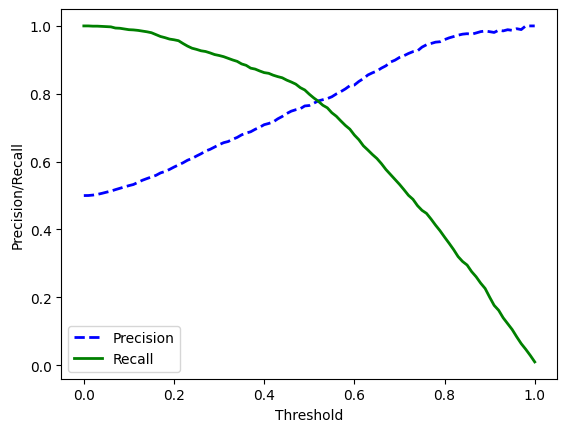

In [104]:
precision, recall, threshold = precision_recall_curve(y_train_res, y_scores[:, 1])

plt.plot(threshold, precision[:-1], "b--", label="Precision", linewidth=2)
plt.plot(threshold, recall[:-1], "g-", label="Recall", linewidth=2)

plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend(loc="lower left")

plt.show()

In [106]:
print(f'Target threshold to obtain 90% precision is {threshold[np.argmax(precision >= 0.80)]}')
print(f'Target threshold to obtain 90% recall is {threshold[np.argmin(recall >= 0.80)]}')

Target threshold to obtain 90% precision is 0.57
Target threshold to obtain 90% recall is 0.5


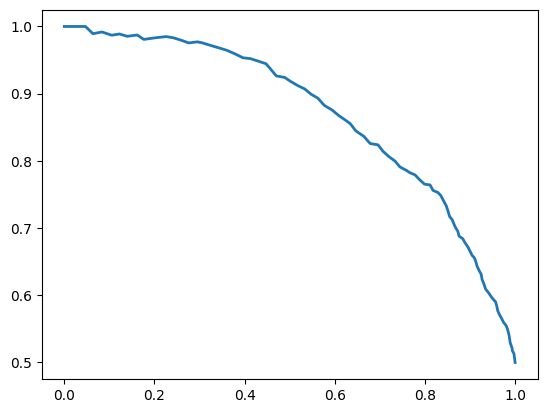

In [ ]:
plt.plot(recall, precision, linewidth=2, label="Precision/Recall curve")
plt.show()

In [108]:
target_threshold = 0.57

clf = RandomForestClassifier(random_state=23)
clf.fit(X_train_res, y_train_res)

y_scores = clf.predict_proba(X_test_transformed)[:, 1]
y_pred = (y_scores >= target_threshold).astype(int)

In [109]:
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

ROC AUC: 0.7874841747373148
Precision: 0.15419265419265418
Recall: 0.717741935483871
F1 Score: 0.25385054192812323


### Modelo final

In [ ]:
final_clf = grid_search.best_estimator_
final_clf.set_params(n_estimators=1000)

undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=23)

X_train_res, y_train_res = undersampler.fit_resample(X_train_transformed, y_train)

final_clf.fit(X_train_res, y_train_res)
y_pred = final_clf.predict(X_test_transformed)

In [115]:
confusion_matrix(y_test, y_pred)

array([[13618,  3479],
       [  133,   487]])

In [ ]:
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

ROC AUC: 0.7909989396366464
Precision: 0.12279374684820979
Recall: 0.785483870967742
F1 Score: 0.21238552115133014
